In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [6]:
import torch
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

## Load dataset

In [3]:
from personalized_nlp.datasets.emotions.emotions import EmotionsDataModule
from personalized_nlp.datasets.cawi1.meanings import MeaningsDataModule

import pandas as pd

## Import datasets

In [4]:
regression = True
embeddings_type = 'xlmr'
x = EmotionsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                batch_size=1000)
x.prepare_data()
x.setup()

In [19]:
text_stds = x.annotations.groupby('text_id').std().iloc[:, 1:]
(text_stds < 0.1).sum(axis=0)

OCZEKIWANIE                0
POBUDZENIE EMOCJONALNE     0
RADOŚĆ                    32
SMUTEK                    33
STRACH                    25
WSTRĘT                    51
ZASKOCZENIE                0
ZAUFANIE                  17
ZNAK EMOCJI                1
ZŁOŚĆ                     41
fold                       0
dtype: int64

In [4]:
regression = True
embeddings_type = 'xlmr'
cawi1_data_module = MeaningsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                batch_size=1000)
cawi1_data_module.prepare_data()
cawi1_data_module.setup()

cawi2_data_module = EmotionsDataModule(embeddings_type=embeddings_type, normalize=regression,
                                batch_size=1000)
cawi2_data_module.prepare_data()
cawi2_data_module.setup()

In [5]:
cawi1_annotators = sorted(cawi1_data_module.annotator_id_idx_dict.keys())
cawi2_annotators = sorted(cawi2_data_module.annotator_id_idx_dict.keys())

len(set(cawi1_annotators).intersection(cawi2_annotators))

193

## Load embeddings

In [6]:
cawi1_embeddings_dict = pickle.load(open('/mnt/big_one/persemo/mgruza/humor-personalization/cawi1_embeddings.p', 'rb'))
cawi2_embeddings_dict = pickle.load(open('/mnt/big_one/persemo/mgruza/humor-personalization/cawi2_embeddings.p', 'rb'))

In [7]:
cawi1_embeddings = []
cawi2_embeddings = []

for annotator_id in cawi1_embeddings_dict.keys():
    if annotator_id in cawi2_embeddings_dict:
        cawi1_embeddings.append(cawi1_embeddings_dict[annotator_id])
        cawi2_embeddings.append(cawi2_embeddings_dict[annotator_id])

cawi1_embeddings = np.vstack(cawi1_embeddings)
cawi2_embeddings = np.vstack(cawi2_embeddings)


## Compute distances

In [9]:
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr

In [16]:
cawi1_distances = distance_matrix(cawi1_embeddings, cawi1_embeddings).flatten()
cawi2_distances = distance_matrix(cawi2_embeddings, cawi2_embeddings).flatten()

cawi1_distances = (cawi1_distances - cawi1_distances.mean()) / cawi1_distances.std()
cawi2_distances = (cawi2_distances - cawi2_distances.mean()) / cawi2_distances.std()

pearsonr(cawi1_distances, cawi2_distances)

(0.3256706931290672, 0.0)

In [17]:
distances_df = pd.DataFrame({'cawi1_distances': cawi1_distances, 'cawi2_distances': cawi2_distances})

<Figure size 1080x1080 with 0 Axes>

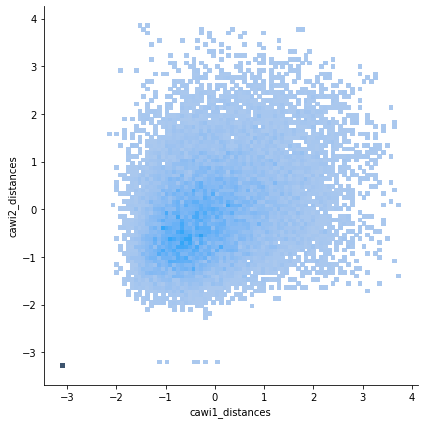

In [18]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.displot(data=distances_df, x='cawi1_distances', y='cawi2_distances', height=6)

## CCA

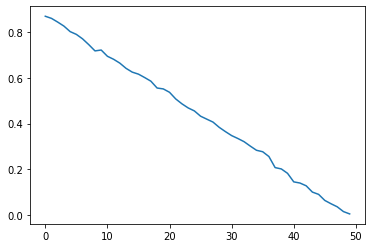

In [19]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=50)
cca.fit(cawi1_embeddings, cawi2_embeddings)
x_c, y_c = cca.transform(cawi1_embeddings, cawi2_embeddings)

dimension_correlations = []

for i in range(50):
    correlation = pearsonr(x_c[:, i], y_c[:, i])
    dimension_correlations.append(correlation[0])

plt.plot(dimension_correlations)   
plt.show()